## QTLs called from principal components of gene clusters identify new variant associations


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from tqdm.auto import tqdm 
tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

a) Upset plot showing number coloc of pcQTLs and eQTLs 


In [ ]:
# takes ~ 1:45
underlying_signals = load_across_tissues(config, load_signal_groups)
underlying_signals = remove_cross_map(underlying_signals, config=config)

In [131]:
underlying_signals['upset_color_label'] = np.where(underlying_signals['num_e_coloc'] > 0, np.where(underlying_signals['num_pc_coloc'] > 0, 'shared', 'eqtl_only'), 'pcqtl_only')
underlying_signals['upset_color_label_multiple'] = underlying_signals['upset_color_label']
underlying_signals.loc[((underlying_signals['upset_color_label'] == 'shared') & (underlying_signals['num_e_coloc'] > 1)),'upset_color_label_multiple'] = 'multiple_e_and_pc'
underlying_signals.loc[((underlying_signals['upset_color_label'] == 'eqtl_only') & (underlying_signals['num_e_coloc'] > 1)),'upset_color_label_multiple'] = 'multiple_e'

underlying_signals['upset_color_label_multiple'] = pd.Categorical(underlying_signals['upset_color_label_multiple'] ,
                                                                ['multiple_e', 'eqtl_only', 'pcqtl_only', 'multiple_e_and_pc', 'shared'])
underlying_signals['exclusive_label'] = np.where((underlying_signals['num_e_coloc'] > 0), np.where((underlying_signals['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

/local/scratch/klawren/slrmtmp.47304989/ipykernel_34306/2914816573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals['upset_color_label'] = np.where(underlying_signals['num_e_coloc'] > 0, np.where(underlying_signals['num_pc_coloc'] > 0, 'shared', 'eqtl_only'), 'pcqtl_only')
/local/scratch/klawren/slrmtmp.47304989/ipykernel_34306/2914816573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals['upset_color_label_multiple'] = underlying_signals['upset_color_label']
/local

/local/scratch/klawren/slrmtmp.47304989/ipykernel_34306/3055866741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals['multiple_e_color_label'] = np.where(underlying_signals['num_e_coloc'] > 1, '>1 eQTLs', np.where(underlying_signals['num_e_coloc'] > 0, '1 eQTL', '0 eQTLs'))
/local/scratch/klawren/slrmtmp.47304989/ipykernel_34306/3055866741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals['eQTL'] = underlying_signals['num_e_coloc'] > 0
/local/scratch/klawren/slrmtmp

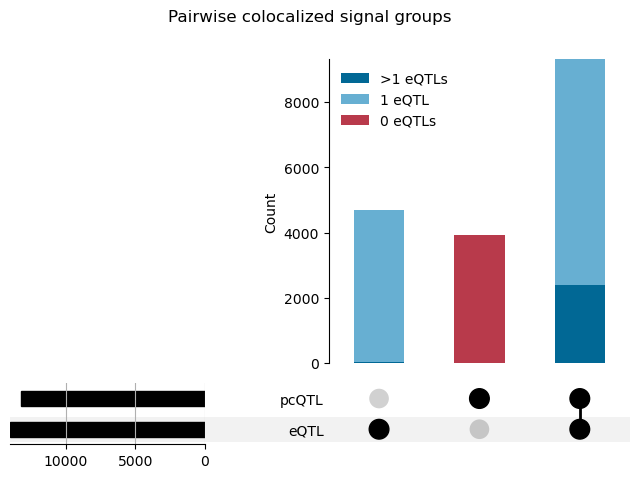

In [132]:
underlying_signals['multiple_e_color_label'] = np.where(underlying_signals['num_e_coloc'] > 1, '>1 eQTLs', np.where(underlying_signals['num_e_coloc'] > 0, '1 eQTL', '0 eQTLs'))
underlying_signals['eQTL'] = underlying_signals['num_e_coloc'] > 0
underlying_signals['pcQTL'] = underlying_signals['num_pc_coloc'] > 0
upset = underlying_signals.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(8,5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_color_label", title="Count", elements=8, colors=('#B83A4B', '#67AFD2','#016895'))
# upset.style_categories(["eQTL"], bar_facecolor="#67AFD2", bar_edgecolor=None)
# upset.style_categories(["pcQTL"], bar_facecolor="#B83A4B", bar_edgecolor=None)

upset.plot(fig=fig)
plt.grid(False)

plt.legend(loc='upper left')
leg = plt.gca().get_legend()
leg.set_title('')
leg.set_frame_on(False)

plt.suptitle('Pairwise colocalized signal groups')
plt.show()


b) pcQTLs have smaller effect sizes than eQTLs, showing increased power to detect them

In [137]:
susie_annotated = load_across_tissues(config, load_susie_annotated)
susie_annotated = remove_cross_map(susie_annotated, config=config)

In [138]:
# some did not annotate properly, not sure why? just remove for now
print(len(susie_annotated))
susie_annotated = susie_annotated[~(susie_annotated['egene_id_list'] == '[nan]')]
print(len(susie_annotated))
# to calculate cv, we need eqtl slope and eqtl slope se
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].progress_apply(ast.literal_eval)
susie_annotated['egene_qtl_slope_se'] = susie_annotated['egene_qtl_slope_se'].progress_apply(ast.literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].progress_apply(ast.literal_eval)

609650
602435


  0%|          | 0/602435 [00:00<?, ?it/s]

  0%|          | 0/602435 [00:00<?, ?it/s]

  0%|          | 0/602435 [00:00<?, ?it/s]

In [153]:
# calculate the cv for each egene in the cluster
susie_egene_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_qtl_slope_se', 'egene_id_list'])
# we take cv = sd/mean
# # becuase we are interested in the magnitude, not direction of effect, take the abs of the mean
susie_egene_explode['pip_egene_cv'] = (susie_egene_explode['egene_qtl_slope_se']/susie_egene_explode['egene_qtl_slope'].abs()) * susie_egene_explode['pip'] * 100
susie_egene_explode['pip_egene_var'] = susie_egene_explode['egene_qtl_slope']**2 * susie_egene_explode['pip']

# group by egene
egene_grouped = susie_egene_explode.groupby(['phenotype_id', 'tissue_id', 'cs_id', 'egene_id_list', 'cluster_id']).agg({'pip_egene_cv':'sum', 'pip_egene_var':'sum', 'type':'first'})
# group into credible sets, take the smallest CV (lowest error)
cs_grouped = egene_grouped.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg({'pip_egene_cv':'min', 'pip_egene_var':'max', 'type':'first'}).reset_index()
# merge into coloc signal groups
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
underlying_signals_explode = pd.merge(underlying_signals.explode('cs_id'), cs_grouped[['cs_id', 'tissue_id', 'pip_egene_cv', 'pip_egene_var']], on=['cs_id', 'tissue_id'], how='left')
underlying_signals_annotated = underlying_signals_explode.groupby(['signal_id', 'tissue_id']).agg({'pip_egene_cv':'min', 'pip_egene_var':'max', 'num_e_coloc':'first', 'num_pc_coloc':'first', 'exclusive_label':'first'})

/local/scratch/klawren/slrmtmp.47304989/ipykernel_34306/1103025610.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')


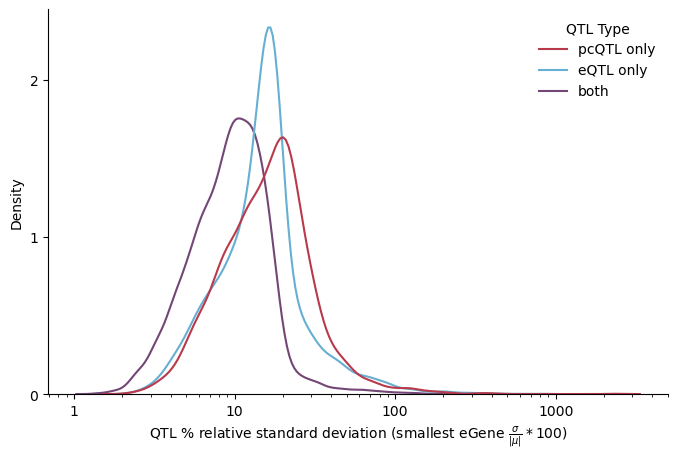

In [140]:
mpl.rcParams['figure.dpi']= 100
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(underlying_signals_annotated, x='pip_egene_cv', hue='exclusive_label', common_norm=False, log_scale=True, ax=ax,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel(r'QTL % relative standard deviation (smallest eGene $\frac{\sigma}{|\mu|}*100$)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

# simplify y ticks
ax.set_yticks([0, 1, 2])
# simplify x ticks
ax.set_xticks([1, 10, 100, 1000], labels=[1, 10, 100, 1000])


mpl.rcParams['figure.dpi']= 100

### distance

are pcqtls further away? no

In [159]:
susie_annotated['pip_min_distance'] = susie_annotated['cluster_min_distance'] * susie_annotated['pip']
# group by credible sets, weight by pip
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg({'pip_min_distance':'sum', 'type':'first'}).reset_index()
# merge into coloc signal groups
underlying_signals_annotated.reset_index(inplace=True)
underlying_signals_annotated['cs_id'] = underlying_signals_annotated['signal_id'].str.split('-')
underlying_signals_explode = pd.merge(underlying_signals_annotated.explode('cs_id'), cs_grouped[['cs_id', 'tissue_id', 'pip_min_distance']], on=['cs_id', 'tissue_id'], how='left')
underlying_signals_annotated = underlying_signals_explode.groupby(['signal_id', 'tissue_id']).agg({'pip_min_distance':'mean', 'pip_egene_var':'first', 'num_e_coloc':'first', 'num_pc_coloc':'first', 'exclusive_label':'first'})

<AxesSubplot: xlabel='pip_min_distance', ylabel='pip_egene_var'>

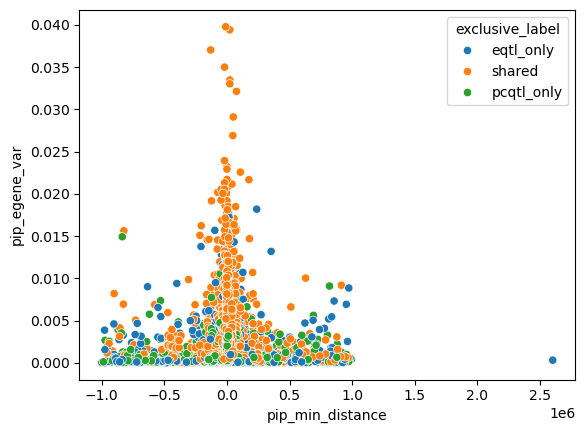

In [176]:
sns.scatterplot(underlying_signals_annotated, y='pip_egene_var', x='pip_min_distance', hue='exclusive_label')

In [161]:
# some are nans, not sure why?
underlying_signals_annotated = underlying_signals_annotated[~underlying_signals_annotated['pip_min_distance'].isna()]

In [162]:
print(ttest_ind(underlying_signals_annotated[underlying_signals_annotated['exclusive_label']=='pcqtl_only']['pip_min_distance'], underlying_signals_annotated[underlying_signals_annotated['exclusive_label']=='eqtl_only']['pip_min_distance']))

Ttest_indResult(statistic=-1.044851435164144, pvalue=0.29612186669107265)


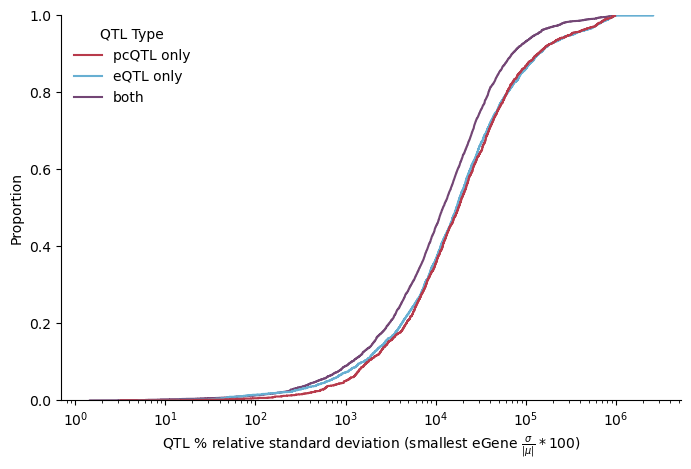

In [163]:
mpl.rcParams['figure.dpi']= 100
fig, ax = plt.subplots(figsize=(8,5))
sns.ecdfplot(underlying_signals_annotated, x='pip_min_distance', hue='exclusive_label', log_scale=True, ax=ax,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel(r'QTL % relative standard deviation (smallest eGene $\frac{\sigma}{|\mu|}*100$)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

# # simplify y ticks
# ax.set_yticks([0, 1, 2])
# # simplify x ticks
# ax.set_xticks([1, 10, 100, 1000], labels=[1, 10, 100, 1000])


mpl.rcParams['figure.dpi']= 100

In [147]:
import statsmodels.api as sm


In [172]:
underlying_signals_non_overlap = underlying_signals_annotated[underlying_signals_annotated['exclusive_label'].isin(['pcqtl_only', 'eqtl_only'])]
underlying_signals_non_overlap['has_pcqtl'] = underlying_signals_non_overlap['num_pc_coloc'] > 0

/local/scratch/klawren/slrmtmp.47304989/ipykernel_34306/3576957677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals_non_overlap['has_pcqtl'] = underlying_signals_non_overlap['num_pc_coloc'] > 0


In [173]:
x = underlying_signals_non_overlap[['pip_min_distance', 'pip_egene_var']].astype(float)
y = underlying_signals_non_overlap['has_pcqtl'].values.astype(bool)
x_with_constant = sm.add_constant(x) 
logit_model = sm.Logit(y, x_with_constant)

result = logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.686122
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8357
Model:                          Logit   Df Residuals:                     8354
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Dec 2024   Pseudo R-squ.:                0.004815
Time:                        11:22:03   Log-Likelihood:                -5733.9
converged:                       True   LL-Null:                       -5761.7
Covariance Type:            nonrobust   LLR p-value:                 8.920e-13
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0315      0.029     -1.076      0.282      -0.089       0.026
pip_min_dis